# Lotka Volterra model

This notebook accompanies the paper "Traced Dynamic Categories".

Our goal is to construct a program which performs a simulation akin to the 
Netlogo model [Wolf Sheep Predation](http://ccl.northwestern.edu/netlogo/models/WolfSheepPredation).


## Setup 

The first step in working with ACSets is to pick a schema. We will model the 
state of the world with the following schema:

<img src="assets/schema.png" alt="schema" width=300/>

The below code creates an ACSet datatype for this schema as well as an 
extension which adds coordinate information to the vertices, which will be useful
when trying to visualize the state of the world.

In [1]:
using Pkg; 
Pkg.activate("..")
using Revise
using Catlab, Catlab.Theories, Catlab.Graphs, Catlab.CategoricalAlgebra
using AlgebraicRewriting 

@present SchLV <: SchGraph begin 
  (Wolf,Sheep, WEng, SEng)::Ob
  w::Hom(Wolf, E)
  s::Hom(Sheep,E)
  we::Hom(WEng,Wolf)
  se::Hom(SEng,Sheep)
  𝔹::AttrType 
  grass::Attr(V,𝔹)
end 
@acset_type AbstractLV(SchLV) <: HasGraph
const LV = AbstractLV{Bool}

@present SchLV_with_coordinates <: SchLV begin 
  Coord::AttrType 
  coord::Attr(V,Coord)
end

@acset_type AbstractLV_with_coordinates(SchLV_with_coordinates) <: HasGraph
const LV_with_coordinates = AbstractLV_with_coordinates{Bool,Tuple{Int,Int}}

  Activating project at `~/code/AlgebraicRewriting.jl/docs`
[ Info: Precompiling AlgebraicRewriting [725a01d3-f174-5bbd-84e1-b9417bad95d9]


LV_with_coordinates (alias for AbstractLV_with_coordinates{Bool, Tuple{Int64, Int64}})

There are some relationships between these schemas which we can codify with 
functors. Furthermore, we can use these functors to perform useful data 
migration! For example, there is an endofunctor on `SchLV` that swaps wolf-things
and sheep-things.

In [2]:
Swap = Migrate(
  Dict(:Sheep=>:Wolf, :Wolf=>:Sheep, :SEng=>:WEng, :WEng=>:SEng, :V=>:V, :E=>:E), 
  Dict([:s=>:w, :w=>:s, :se=>:we, :we=>:se,:grass =>:grass,:src=>:src, :tgt=>:tgt,]), LV);

There is also a functor $SchLV \hookrightarrow SchLV\_with\_coordinates$ which 
will be used for $\Sigma$ migration.

In [3]:
Coords = Migrate(
  Dict(x=>x for x in Symbol.(SchLV.generators[:Ob])), 
  Dict(x=>x for x in Symbol.(SchLV.generators[:Hom])), LV_with_coordinates; delta=false);

We now write a function which initializes a n x n grid to serve as our initial simulation input. 

In [4]:
using Random 
Random.seed!(123);

"""
Create a nxn grid with periodic boundary conditions. Edges in each cardinal
direction originate at every point


(i,j+1) -> (i+1,j+1) -> ...
  ↑          ↑
(i,j)   -> (i+1,j)   -> ...

"""
function create_grid(n::Int, prob::Float64=0.5)
  lv = LV_with_coordinates()
  coords = Dict()
  for i in 0:n-1
    for j in 0:n-1
      coords[i=>j] = add_part!(lv, :V; grass=(rand() > prob), coord=(i,j))
    end
  end
  for i in 0:n-1
    for j in 0:n-1
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[mod(i+1,n)=>j])
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[mod(i-1,n)=>j])
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[i=>mod(j+1,n)])
      add_part!(lv, :E; src=coords[i=>j], tgt=coords[i=>mod(j-1,n)])
    end
  end
  return lv
end


"""
`n` is the length of the grid. 
`n_eng` is the number of energy all animals start with.
`sheep` and `wolves` are the fraction of spaces that are populated with that animal
"""
function initialize(n::Int, n_eng::Int=5, sheep::Float64=0.5, wolves::Float64=0.5)
  grid = create_grid(n)
  args = [(sheep, :Sheep, :s, :SEng, :se,),
          (wolves, :Wolf, :w, :WEng, :we,)]
  for (n_, name, loc, eng, e) in args
    for _ in 1:round(Int,n_*n^2)
      dic = Dict([loc => rand(edges(grid)),])
      p = add_part!(grid, name; dic...)
      add_parts!(grid, eng, n_eng; Dict(e=>p)...)
    end
  end
  return grid
end

initialize(2, 1) # 2x2 grid with 2 wolves and 2 sheep, all with 1 energy

V,grass,coord
1,true,"(0, 0)"
2,true,"(0, 1)"
3,true,"(1, 0)"
4,false,"(1, 1)"
E,src,tgt
1,1,3
2,1,3
3,1,2
4,1,2
5,2,4


Now we need a function to properly visualize grid-like graphs. Green dots are vertices with grass, red squares are wolves, blue squares are sheep, and their energy is indicated by an integer. The direction being faced is indicated by position on the vertex. 

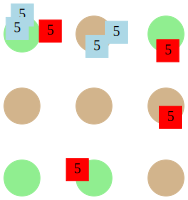

In [5]:
using Catlab.Graphics.Graphviz
using Catlab.Graphics.Graphviz: Attributes, Statement, Node

function view_LV(p::LV_with_coordinates; name="G", title="", star=nothing)
  pstr = ["$(i),$(j)!" for (i,j) in p[:coord]]
  stmts = Statement[]
  for s in 1:nv(p)
    gv = p[s, :grass]
    col = gv ? "lightgreen" : "tan"
    push!(stmts,Node("v$s", Attributes(:label=>((star == (:V=>s)) ? "*" : ""),
      :shape=>"circle", :color=> col, :pos=>pstr[s])))
  end

  args = [(true,:Wolf,:w,:we),(false, :Sheep, :s,:se)]

  for (is_wolf, prt, loc, eng) in args
    for w in parts(p, prt)
      st = (star == ((is_wolf ? :Wolf : :Sheep) => w)) ? "*" : ""
      e = p[w,loc]
      s, t = src(p,e), tgt(p,e)
      (sx,sy), (tx,ty) = p[s,:coord], p[t,:coord]
      dx_, dy_ = (tx - sx), (ty - sy)
      dx, dy = map([dx_,dy_]) do dxy 
        if dxy > 1      return -1 
        elseif dxy < -1 return 1 
        else            return dxy 
        end
      end
      peng = incident(p, w, eng) |> length

      L, R = 0.25, 0.2
      wx = sx+L*dx+R*rand()
      wy = sy+L*dy+R*rand()
      ID = "$(is_wolf ? :w : :s)$w"
      append!(stmts,[Node(ID, Attributes(
        :label=>"$peng"*st,
        :shape=>"square", :width=>"0.3px", :height=>"0.3px", :fixedsize=>"true",
        :pos=>"$(wx),$(wy)!",:color=> is_wolf ? "red" : "lightblue"))])
    end
  end

  g = Graphviz.Digraph(name, Statement[stmts...]; prog="neato",
        graph_attrs=Attributes(:label=>title, :labelloc=>"t"),
        node_attrs=Attributes(:shape=>"plain", :style=>"filled"))
  return g
end

X = initialize(3)
view_LV(X)

If we have a wolf/sheep/vertex shaped agent, we want to be able to show this 
fact visually, too. The following example shows when a wolf is distinguished.

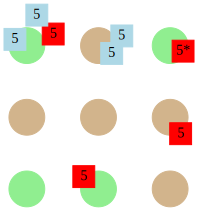

In [6]:
const Var = AttrVar # shorthand
Base.isless(x::Var,y::Var) = x.val < y.val

"""Visualize a LV with a distinguished focus"""
function view_LV(p::ACSetTransformation; name="G", title="")
  if nparts(dom(p),:Wolf) == 1 
    star = :Wolf=>p[:Wolf](1)
  elseif nparts(dom(p),:Sheep) == 1 
    star = :Sheep=>p[:Sheep](1)
  elseif nparts(dom(p),:V) == 1 
    star = :V=>p[:V](1)
  else
    star = nothing
  end
  view_LV(codom(p); name=name, title=title, star=star)
end

# Empty agent type
I = LV()
# Generic sheep agent
S = @acset LV begin Sheep=1; V=2; E=1; src=1; tgt=2; 𝔹=2; s=1; grass=Var.(1:2) end
# Generic wolf agent
W = Swap(S)
# Generic grass agent
G = @acset LV begin V=1; 𝔹=1; grass=[Var(1)] end

view_LV(homomorphism(Coords(W), X)) # Example with a distinguished wolf 

## Defining rewrite rules 
We are now ready to begin constructing rewrite rules! We start with sheep 
eating grass. Our pattern is a sheep on a vertex. A positive application 
condition ensures that grass is present on the vertex for the rewrite to be 
applicable. The attribute is turned to `false`, and the sheep gains 4 energy 
units. 

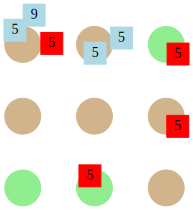

In [7]:
s_eat_pac = deepcopy(S)
s_eat_pac[:grass] = [true, AttrVar(1)]
rem_part!(s_eat_pac, :𝔹, 1)

pac = AppCond(homomorphism(S,s_eat_pac; initial=(𝔹=[true,Var(1)],)))

sheep_eat_R = deepcopy(S)
add_parts!(sheep_eat_R, :SEng, 4; se=1)
sheep_eat_r = homomorphism(S,sheep_eat_R)

exprs = (𝔹=[vs->false, vs->vs[1]],) # new attributes are a function of the old ones
se_rule = Rule(id(S), sheep_eat_r; expr=exprs, ac=[pac])
view_LV(rewrite(Coords(se_rule), X))

Now for wolves eating sheep. 

Note that. in DPO, we cannot naively delete the sheep that 
is eaten because there are sheep energy units that are referring to that sheep. This is 
known as the "dangling condition" for DPO rewriting. However, if we give the rule 
*single pushout* (SPO) semantics, we can write a rule that simply deletes the 
sheep, because the semantics of SPO is to cascade delete anything that refers to a deleted 
item.

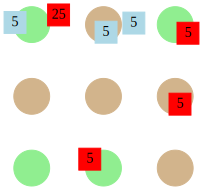

In [8]:
w_eat_L = @acset LV begin
  Sheep=1; Wolf=1; E=2; V=3; 𝔹=3; grass=Var.(1:3); s=1; w=2; src=1; tgt=[2,3]
end

w_eat_I = @acset LV begin
  Wolf=1; E=2; V=3; 𝔹=3; grass=Var.(1:3); s=1; w=2; src=1; tgt=[2,3]
end

w_eat_R = @acset LV begin
  Wolf=1;WEng=20;E=2;V=3;𝔹=3;grass=Var.(1:3);w=2;src=1;tgt=[2,3];we=1
end

w_eat_l = homomorphism(w_eat_I, w_eat_L; initial=(E=[1,2],))
w_eat_r = homomorphism(w_eat_I, w_eat_R; initial=(E=[1,2],))
we_rule = Rule{:SPO}(w_eat_l,w_eat_r)

view_LV(rewrite(Coords(we_rule), X))

Speaking of deleting things, let's encode the starvation rule, which will also need SPO semantics. We use a *negative application condition* to characterize that the match is invalid if there exists an energy unit pointing at our sheep that we delete.

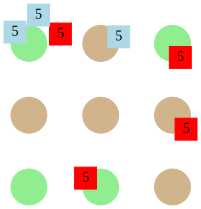

In [9]:
s_starve_L, s_starve_I, s_starve_N = [deepcopy(S) for _ in 1:3]
rem_part!(s_starve_I, :Sheep, 1)
add_part!(s_starve_N, :SEng; se=1)

s_starve_l = homomorphism(s_starve_I,s_starve_L; monic=true)
s_starve_n = homomorphism(s_starve_L,s_starve_N; monic=true)

s_starve_rule = Rule{:SPO}(s_starve_l, id(s_starve_I); ac=[AppCond(s_starve_n, false)])

rem_parts!(X, :SEng, incident(X, 2, :se)) # remove Sheep#2's energy
view_LV(rewrite(Coords(s_starve_rule), X))

We'll let reproduction work in the following way: a sheep/wolf with at least 10 
energy will give 5 of its energy to create a new one.

Sheep energies Before: [11, 0, 5, 5]
Sheep energies After: [6, 5, 0, 5, 5]


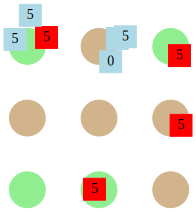

In [10]:
s_reprod_L = @acset LV begin
  Sheep=1; SEng=10; E=1; V=2; 𝔹=2; grass=Var.(1:2); s=1; src=1; tgt=2; se=1
end

s_reprod_I = @acset LV begin
  Sheep=1; SEng=5; E=1; V=2; 𝔹=2; grass=Var.(1:2); s=1; src=1; tgt=2; se=1
end

s_reprod_R = @acset LV begin
  Sheep=2; SEng=10; E=1; V=2; 𝔹=2; grass=Var.(1:2); s=1; src=1; tgt=2; 
  se=vcat(fill(1,5),fill(2,5))
end

s_reprod_l = homomorphism(s_reprod_I, s_reprod_L; monic=true)
s_reprod_r = homomorphism(s_reprod_I, s_reprod_R; monic=true)
s_reprod_rule = Rule(s_reprod_l, s_reprod_r; monic=true)

add_parts!(X,:SEng,6; se=1)
res = rewrite(Coords(s_reprod_rule), X)
for (txt, cset) in [("Before",X), ("After", res)]
  vec = [length(incident(cset,i,:se)) for i in parts(cset,:Sheep)]
  println("Sheep energies $txt: $vec")
end
view_LV(res)